In [ ]:
######### Create Stable Diffusion endpoint from JumStart model
# look for detailed instruction here:
# https://github.com/aws/studio-lab-examples/blob/main/generative-deep-learning/stable-diffusion-finetune/JumpStart_Stable_Diffusion_Inference_Only.ipynb
# 

In [1]:
# Step 1 - inital configuration
import sagemaker, boto3, json
from sagemaker import get_execution_role

try:
    aws_role = sagemaker.get_execution_role()
except:
    iam = boto3.client("iam")
    # TODO: replace with your role name (i.e. "AmazonSageMaker-ExecutionRole-20211014T154824")
    aws_role = iam.get_role(RoleName="<replace with your RoleName>")["Role"]["Arn"]

boto_session = boto3.Session()
aws_region = boto_session.region_name
sess = sagemaker.Session(boto_session=boto_session)

print(aws_role)
print(aws_region)
print(sess.boto_region_name)

arn:aws:iam::616815736523:role/service-role/AmazonSageMaker-ExecutionRole-20230114T015275
us-east-1
us-east-1


In [2]:
# Step 2 - select model for use

from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

Dropdown(description='Select a model', index=84, layout=Layout(width='max-content'), options=('huggingface-txt…

In [3]:
#### Step 2.1 - fetches model version
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

print ("Selected: ", model_id)


Selected:  model-txt2img-stabilityai-stable-diffusion-v2-1-base


In [4]:
%%time
##### Step 3 -  Deploy endpoint with model selected
#####################################################################################
##   !!!!! This step may take up to 10 minutes !!!!!
##   This step will couse increased spend in your AWS account, shutdown endpoint 
##   then you complete testing to avoid unecessery charges 
##
#####################################################################################
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
# inference_instance_type = "ml.g4dn.2xlarge"
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the pre-trained nvidia-ssd model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

print("Endpoint name: ", endpoint_name)

----------!Endpoint name:  jumpstart-example-infer-model-txt2img-s-2023-05-14-12-36-43-077
CPU times: user 5min 36s, sys: 39.4 s, total: 6min 16s
Wall time: 12min 35s


In [ ]:
############################################################
## Endpoint created - let's check before going to lambda   #
############################################################

In [30]:
%%time
#### Step 4 - Test endpoint work with boto3

######################################################
# Check endpoint proper work through boto3 call      #
######################################################
# Create image from result
from io import BytesIO
import base64
from PIL import Image
import json

#ENDPOINT_NAME = "jumpstart-example-infer-model-txt2img-s-2023-05-14-12-36-43-077"
ENDPOINT_NAME = endpoint_name

runtime = boto3.client('runtime.sagemaker')
parameters = {    "action": "create", "prompt": "new model BMW X3 on the road heads up to mountains on the horizon"}
#
print ("Call endpoint: ", ENDPOINT_NAME )
print ("With parameters: ", parameters)

#query_response = query(model_predictor, request)
request_parametes = {}
# transfer to request_parameters only valid fields
for i in ['prompt', 'negative_prompt', 'seed']:
    if i in parameters:
        request_parametes[i] = parameters[i]

encoded_text = json.dumps(request_parametes).encode("utf-8")
response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                   ContentType='application/json',
                                   Body=encoded_text)
print ("Received reply from endpoint, len: ", len(response))
response_image = response["Body"]
stream = response_image.read()
data = json.loads(stream)

import numpy as np
responce_array = data['generated_images'][0]
# create Image from stream
new_image = Image.fromarray(np.array(responce_array).astype('uint8'), 'RGB')


Call endpoint:  jumpstart-example-infer-model-txt2img-s-2023-05-14-12-36-43-077
With parameters:  {'action': 'create', 'prompt': 'new model BMW X3 on the road heads up to mountains on the horizon'}
Received reply from endpoint, len:  4
CPU times: user 508 ms, sys: 20.1 ms, total: 529 ms
Wall time: 10.2 s


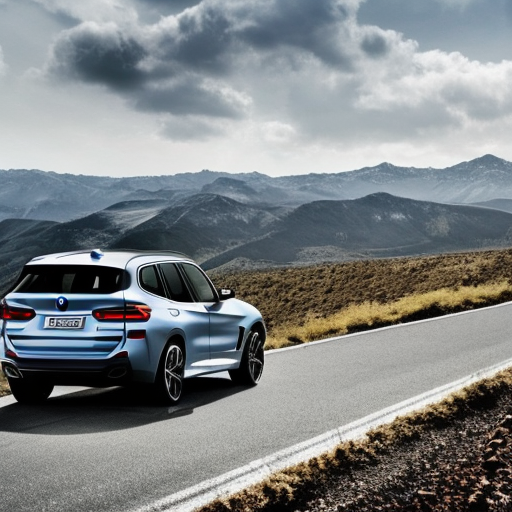

In [31]:
new_image